<a href="https://colab.research.google.com/github/yqwang1/Computational_Neuro/blob/main/NEUR0019_In_Course_Assessment_2024_25_Information_Theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# download the class data and library

!git clone https://github.com/kdharris101/NeuralCodingClass.git

Cloning into 'NeuralCodingClass'...
remote: Enumerating objects: 277, done.
remote: Total 277 (delta 0), reused 0 (delta 0), pack-reused 277 (from 1)
Receiving objects: 100% (277/277), 369.09 MiB | 9.77 MiB/s, done.
Resolving deltas: 100% (100/100), done.
Updating files: 100% (260/260), done.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from scipy import special
from scipy import stats

import NeuralCodingClass.neurocode as nc

In [ ]:
# load the data
FileDir = r'NeuralCodingClass/data/bush'
Experiment = 'Patient1Session1'

spikes=nc.load_object(os.path.join(FileDir, Experiment, 'spikes'))
stims=nc.load_object(os.path.join(FileDir, Experiment, 'stims'))
stims.frames = stims.frames.astype(int) # correct datatype
spikes.clusters = spikes.clusters.astype(int) # correct datatype


In [ ]:
# we have loaded two data objects as a "Bunch", a simple datastructure which
# contains many arrays, all with the same number of rows.

# spikes has one row per spike
# stims has one row per stimulus.

# let's see what's in it:

for k in spikes.keys():
  print(f'spikes.{k:<20}: size {spikes[k].shape}\t dtype {spikes[k].dtype}')

for k in stims.keys():
  print(f'stims.{k:<20}: size {stims[k].shape}\t dtype {stims[k].dtype}')



spikes.times               : size (4668,)	 dtype float64
spikes.clusters            : size (4668,)	 dtype int64
stims.intervals           : size (300, 2)	 dtype float64
stims.frames              : size (300,)	 dtype int64


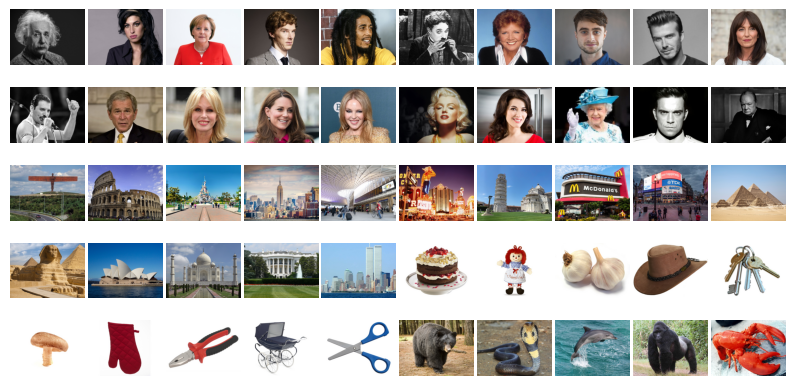

In [ ]:
# Again let's view all the stimuli, which are stored as additional files

fig, ax = plt.subplots(5,10,figsize=(10,5), sharex=True, sharey=True, gridspec_kw={'wspace':.05, 'hspace':.05})
for i in np.arange(50):
    plt.sca(ax.flat[i])
    im = np.load(os.path.join(FileDir, Experiment, 'Image%03d.npy'%i))
    plt.imshow(im, cmap='gray',vmin=0,vmax=255)
    plt.axis('off')

**Here's what the arrays contain:**

spikes.times: time of each spike (seconds)

spikes.clusters: neuron assignment of each spike (int)

stims.intervals: start and stop time of each stimulus trial (seconds)

stims.frames: which stimulus was shown on each trial (int)

In [ ]:
# do some preprocessing to make spike count arrays etc:

nStims = len(stims)
nClusters = spikes.clusters.max().astype(int)+1
nFrames = stims.frames.max().astype(int)+1
nRepeats = 6
print('%d clusters'%nClusters)

# make spike count array, counting for 1s after stimulus onset for each stimulus (they lasted 1s)

pairs = nc.find_close_pairs(spikes.times, stims.intervals[:,0], 0, 1)

stims.spike_counts,_,_ = np.histogram2d(pairs[:,1], spikes.clusters[pairs[:,0]],
                    bins=[np.arange(len(stims)+1), np.arange(nClusters+1)]
                          )

frames = nc.Bunch()
frames.spike_counts = np.zeros((nFrames, nRepeats, nClusters))

for f in np.arange(nFrames):
    my_stims = (stims.frames==f)
    frames.spike_counts[f,:,:] = stims.spike_counts[my_stims,:]



8 clusters


In [ ]:
# now let's measure the mutual information of each cell by cross-validation
# using a Poisson model and leave-one-out cross-validation

# first let's make a function to compute the mean rate on the training set.
# we have to regularize by adding a fraction of the mean over all stimuli

def compute_training_rates(spike_counts, reg=.1):
  '''compute_training_rates(spike_counts, reg=.1)

  estimates the mean rates of each clusters to each frame, averaged over all
  repeats except the test set.

  the estimated mean is (1-reg)*(mean for this frame) + reg*(mean over all frames)

  parameters:
  -----------

  spike_counts: experimental spike counts for each frame, repeat, and cluster
   size (nFrames, nRepeats, nClusters)

   reg: regularization parameter, between 0 (no regularization) and 1 (full)

  returns:
  --------
  train_rate: regularized training set mean rate
    size (nFrames, nRepeats, nClusters)
  train_rate0: size (1, nRepeats, nClusters), averaged over all training stimuli

  '''
  # compute mean spike count over all repeats except the test repeat
  train_rate = np.zeros((nFrames, nRepeats, nClusters))
  for rep in range(nRepeats):
    train_rate[:,rep,:] = np.delete(spike_counts,rep,axis=1).mean(axis=1)

  # average over all frames
  train_rate0 = train_rate.mean(axis=0, keepdims=1)

  # regularize trainRate
  train_rate = (1-reg)*train_rate + reg*train_rate0

  return train_rate, train_rate0



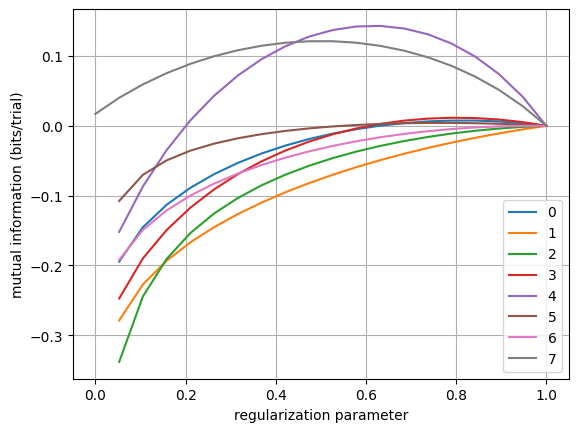

In [ ]:
# now let's look at the mutual information as a function of the regularization
# parameter

reg_range = np.linspace(0,1,20)

mutualInfo = np.zeros((nClusters,len(reg_range)))

for i,reg in enumerate(reg_range):

  train_rate, train_rate0 = compute_training_rates(frames.spike_counts, reg)

  # get the poisson log-likelihood of the stimulus model and mean-rate-model
  logLike = stats.poisson.logpmf(frames.spike_counts, train_rate)
  logLike0 = stats.poisson.logpmf(frames.spike_counts, train_rate0)

  # now mutual information is the difference between the two, averaged over grames,
  # and divided by log 2

  mutualInfo[:,i] = np.mean(logLike-logLike0,axis=(0,1))/np.log(2)

plt.plot(reg_range, mutualInfo.T)
plt.grid()
plt.xlabel('regularization parameter')
plt.ylabel('mutual information (bits/trial)')

plt.legend(range(nClusters))

**QUESTION**: Why does it need such a large regularization parameter? were you expecting that?

**QUESTION**: Why is the mutual information estimate zero when regularization is 1?

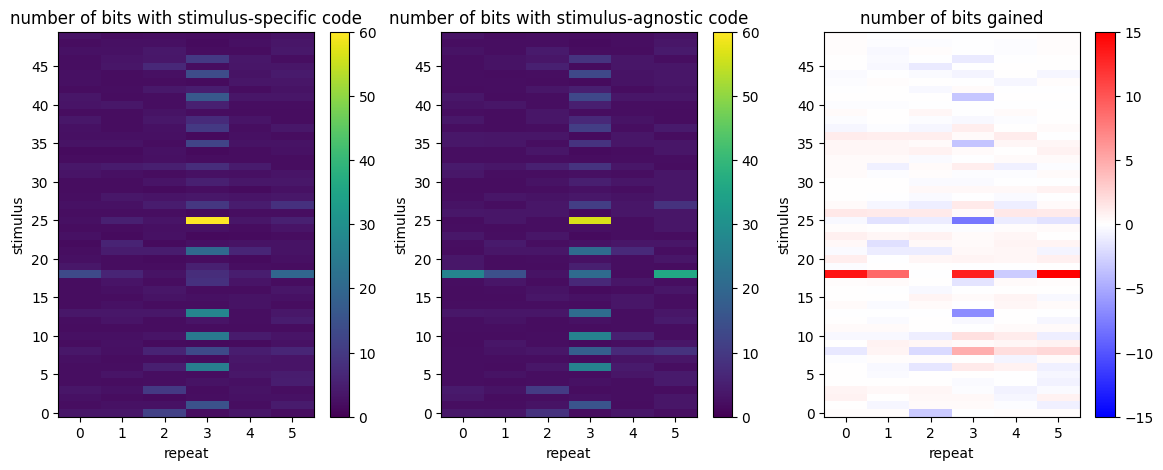

In [ ]:
# the number of bits taken to tell you the spike count (under an optimal code)
# is -log_2 of the poisson likelihood

# let's focus on the Robbie Williams cell (cluster 4) and see which stimuli
# need how many bits to transmit.

reg = 0.6
cell = 4

train_rate, train_rate0 = compute_training_rates(frames.spike_counts, reg)

# get the poisson log-likelihood of the stimulus model and mean-rate-model
logLike = stats.poisson.logpmf(frames.spike_counts, train_rate)
logLike0 = stats.poisson.logpmf(frames.spike_counts, train_rate0)

plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.pcolormesh(-logLike[:,:,cell]/np.log(2), vmin=0,vmax=60)
plt.colorbar()
plt.title('number of bits with stimulus-specific code')

plt.xlabel('repeat')
plt.xticks(np.arange(.5,.5+nRepeats), np.arange(0,nRepeats))
plt.ylabel('stimulus')
plt.yticks(np.arange(.5,.5+nFrames,5), np.arange(0,nFrames,5))

plt.subplot(1,3,2)
plt.pcolormesh(-logLike0[:,:,cell]/np.log(2), vmin=0,vmax=60)
plt.colorbar()
plt.title('number of bits with stimulus-agnostic code')

plt.xlabel('repeat')
plt.xticks(np.arange(.5,.5+nRepeats), np.arange(0,nRepeats))
plt.ylabel('stimulus')
plt.yticks(np.arange(.5,.5+nFrames,5), np.arange(0,nFrames,5))

plt.subplot(1,3,3)
plt.pcolormesh((logLike-logLike0)[:,:,cell]/np.log(2), vmin=-15, vmax=15, cmap='bwr')
plt.colorbar()
plt.title('number of bits gained')
plt.xlabel('repeat')
plt.xticks(np.arange(.5,.5+nRepeats), np.arange(0,nRepeats))
plt.ylabel('stimulus')
plt.yticks(np.arange(.5,.5+nFrames,5), np.arange(0,nFrames,5));


**QUESTION**: What repeats and what stimuli are making positive or negative contributions to the mutual information?  

**QUESTION**: What happens when you make the regularization parameter `reg` smaller?

**EXERCISE**: To try and understand why, make a pseudocolor plot showing the spike count for each stimulus on each repeat (i.e. `frames.spike_counts[:,:,4]`.

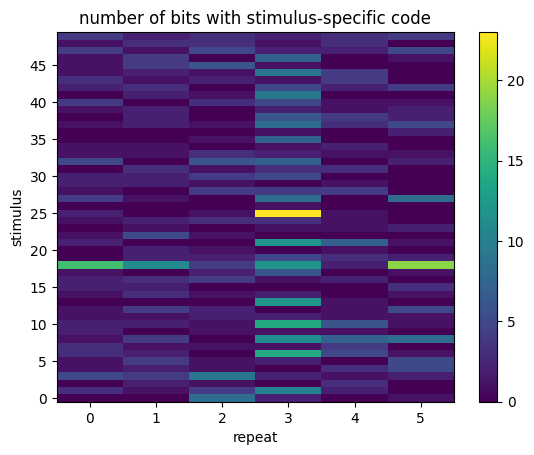

In [ ]:
# answer should look like this ....

**QUESTION**: What happened on repeat 3? How did this affect the mutual information estimate, and why?

**QUESTION**: Which image is frame 25?

**EXERCISE**: Repeat these plots for cell 7, another concept cell.  What happens there?

**EXERCISE**: See what happens when you equalize the mean firing rate of each cell on each repeat to a fixed value.

To do so, create a new variable which is

`10*frames.spike_counts//np.mean(frames.spike_counts,0)` and make the plot of mutual information vs. regularization starting from this.  

(Note that `//` means divide and round the result to an integer, which we need for the Poisson distribution).

You might need to adjust the y-axis limits with plt.ylim().

What happens if you change 10 to a larger or smaller number?


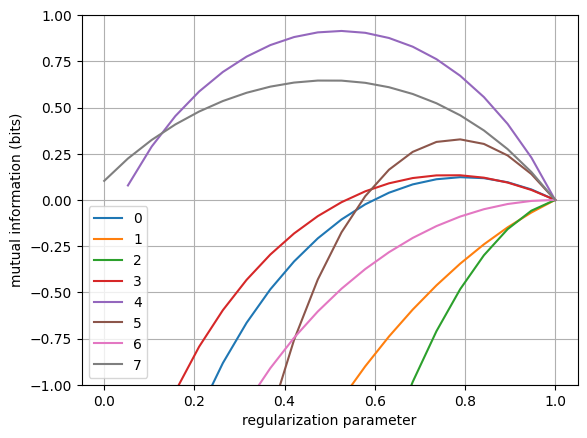

In [ ]:
# answer should look like this ...